This can be run [run on Google Colab using this link](https://colab.research.google.com/github/CS7150/CS7150-Homework-2/blob/main/HW2_3_DenoisingAutoencoder.ipynb)

<font size='6'>**Homework 2.3: Denoising Autoencoder (DAE)**</font>

Denoising Autoencoders are a class of autoencoders where we attempt to remove noise from a customized data. Note the emphasis on the word `customized`. Given that we train a DAE on a particular dataset, it is optimized to remove noise from the samples of that dataset only and will not be suitable on other dataset samples. (Want to learn more on EBM models? Read more on [Energy Based Models](http://yann.lecun.com/exdb/publis/pdf/lecun-06.pdf))

So let's code a simple DAE and explore it's functioning !

In [2]:
# Importing libraries
import matplotlib.pyplot as plt
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Subset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Downloading the dataset
This can be done in few ways:
1. Downloading from  torch library (preferred)
2. From the official portal [here](http://yann.lecun.com/exdb/mnist/). 

Note: If you download from the official portal, you need to write your custom wrapper to read the data into desired variables. 

In [3]:
# downloading mnist into folder
data_dir = 'data' # make sure that this folder is created in your working dir
# transform the PIL images to tensor using torchvision.transform.toTensor method
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
test_data  = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
print(f'Datatype of the dataset object: {type(train_data)}')
# check the length of dataset
print(f'Number of samples in training data: {len(train_data)}')
print(f'Number of samples in test data: {len(test_data)}')
# Check the format of dataset
print(f'Foramt of the dataset: \n {train_data}')

100%|██████████| 9912422/9912422 [00:00<00:00, 202114257.59it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 54223676.73it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 75037339.11it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16710990.15it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Datatype of the dataset object: <class 'torchvision.datasets.mnist.MNIST'>
Number of samples in training data: 60000
Number of samples in test data: 10000
Foramt of the dataset: 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


## Displaying the loaded dataset

/tmp/ipykernel_32/1282461058.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


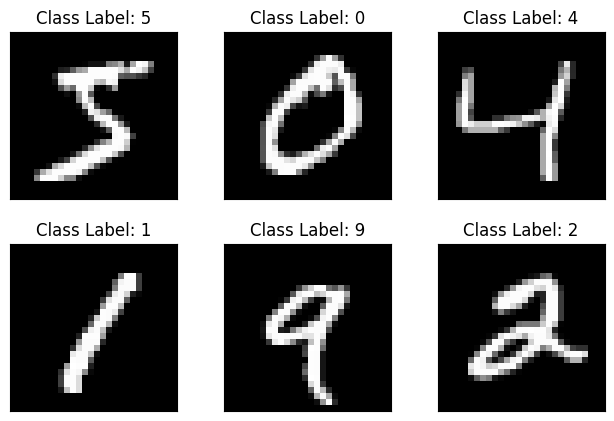

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(train_data[i][0][0], cmap='gray', interpolation='none')
  plt.title("Class Label: {}".format(train_data[i][1]))
  plt.xticks([])
  plt.yticks([])

If your code is running so far without any errors, you are all set to start building the network and train it!

## Building a DAE

In [8]:
class dae(nn.Module):
    def __init__(self, inp_dim = 28*28, device='cuda'):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(inp_dim,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,8)
            )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(8,64),
            nn.Linear(64,256),
            nn.ReLU(),
            nn.Linear(256,28*28),
            nn.Sigmoid(),
            )
        
    def forward(self, inp):
        encoded = self.encoder(inp)
        reconstructed = self.decoder(encoded)
        return reconstructed

## Function to add noise to data

In [9]:
def add_noise(inp,noise_factor=0.3):
    noise = torch.rand(inp.shape) # Creating a noise in the same shape as input 
    noisy_image = inp + noise 
    return noisy_image, noise

## Functions to train and test the DAE

In [10]:
# Training function
def train_dae(model, input_dim, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    # Set the model to train
    model.train()
    # Initiate a loss monitor
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning and not supervised classification)
    for images, labels in dataloader: # the variable `labels` willbe used for customised training
        # Add noise to images
        noisy_images, actual_noise = add_noise(images, noise_factor)
        # move the data to preferred device GPU/CPU
        images = images.to(device)
        noisy_images = noisy_images.to(device)    
        # send the noisy data through DAE to denoise
        # reshape images to fit the FC layers
        noisy_images = torch.reshape(noisy_images,input_dim)
        images = torch.reshape(images,input_dim) 
        
        denoised_images = model(noisy_images)
        
        loss = loss_fn(denoised_images, images)
        # Backward pass (back propagation)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [11]:
# Testing Function
def test_dae(model, input_dim, device, dataloader, loss_fn,noise_factor=0.3):
    # Set evaluation mode for model
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        predicted = []
        actual = []
        for images, labels in dataloader:
            # Add noise to images
            noisy_images, actual_noise = add_noise(images, noise_factor)
            # move the data to preferred device GPU/CPU
            images = images.to(device)
            noisy_images = noisy_images.to(device)    
            # send the noisy data through DAE to denoise
            # reshape the data to fit FC layers
            noisy_images = torch.reshape(noisy_images,input_dim)
            images = torch.reshape(images,input_dim) 
            # denoise the image
            denoised_images = model(noisy_images)
            # Append the network output and the original image to the lists
            predicted.append(denoised_images.cpu())
            actual.append(images.cpu())
        # Create a single tensor with all the values in the lists
        predicted = torch.cat(predicted)
        actual = torch.cat(actual) 
        # Evaluate global loss
        val_loss = loss_fn(predicted, actual)
    return val_loss.data

## Function to plot results

In [12]:
def plot_dae_inference(model, test_dataset, n=10, noise_factor=0.3, save_to_file=''):
    plt.figure(figsize=(15,5))
    labels = test_dataset.targets.numpy()
    idx = {i:np.where(labels==i)[0][0] for i in range(n)}    
    for i in range(n):

        ax = plt.subplot(3,n,i+1)
        ax.set(facecolor = "white")
        image = test_dataset[idx[i]][0].unsqueeze(0)
        noisy_images, _ = add_noise(image, noise_factor)     
        noisy_images = noisy_images.to(device)

        model.eval()

        with torch.no_grad():
            denoised_images  = model(torch.reshape(noisy_images,(-1,28*28)))
            denoised_images = torch.reshape(denoised_images,(-1,1,28,28))

        plt.imshow(image.cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')  
        if i == n//2:
            ax.set_title('Actual Image')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(noisy_images.cpu().squeeze().numpy(), cmap='gray')
        ax.axis('off')  
        if i == n//2:
            ax.set_title('Corrupted Image')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(denoised_images.cpu().squeeze().numpy(), cmap='gray')  
        ax.axis('off')   
        if i == n//2:
            ax.set_title('Denoised Image')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    if len(save_to_file) != 0:
        plt.tight_layout()
        plt.savefig(save_to_file, facecolor='white',transparent=False)
        plt.close()
    else:
        plt.tight_layout()
        plt.show()   

## Initializing the models, optimizer and loss function. Load the model to CPU/GPU device

In [13]:
### Set the random seed for reproducible results
torch.manual_seed(1234)
# Choosing a device based on the env and torch setup
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


### Initialize the network

model = dae(inp_dim=28*28, device=device)
# Move both the encoder and the decoder to the selected device
model.to(device)

params_to_optimize = [
    {'params': model.parameters()}
]
### Define the loss function
loss_fn = torch.nn.MSELoss()
### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

Selected device: cpu


Now let's train the model. Before that, let's test out the EBM theory we were talking about in the introduction. In the below code, we are going to show only certain classes to the model while training to see it's performance generalisation. To explain clearly, let's assume we train the model on samples with 0,1,2,3,4 classes. Now let's see how the model performs on data from the rest of the classes like 5,6,7,8,9. This will be cool to visualise!

DAE training started
---------------------------------------------Epoch 1/30---------------------------------------------

 	 	 	 train loss 0.079 	 val loss 0.058


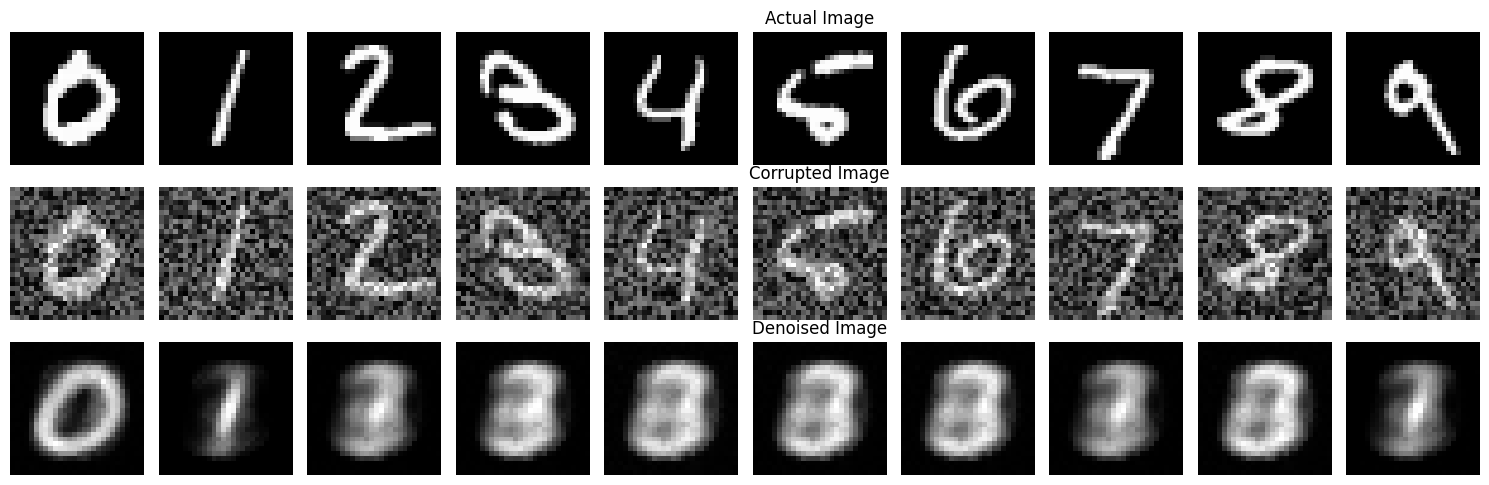

---------------------------------------------Epoch 2/30---------------------------------------------

 	 	 	 train loss 0.054 	 val loss 0.050


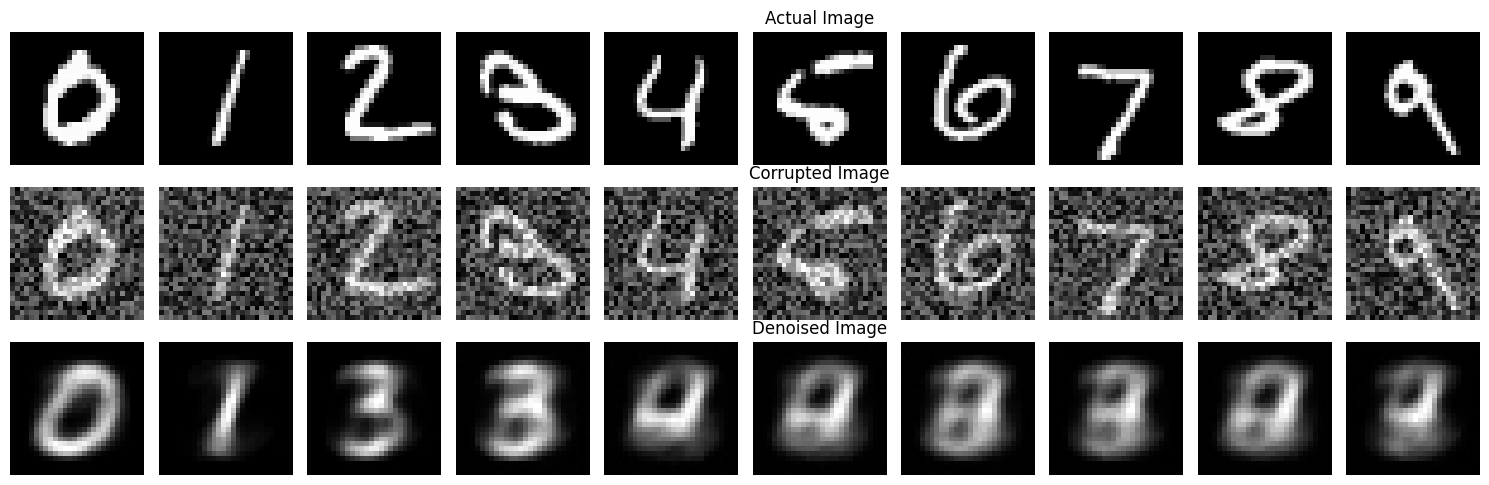

---------------------------------------------Epoch 3/30---------------------------------------------

 	 	 	 train loss 0.047 	 val loss 0.043


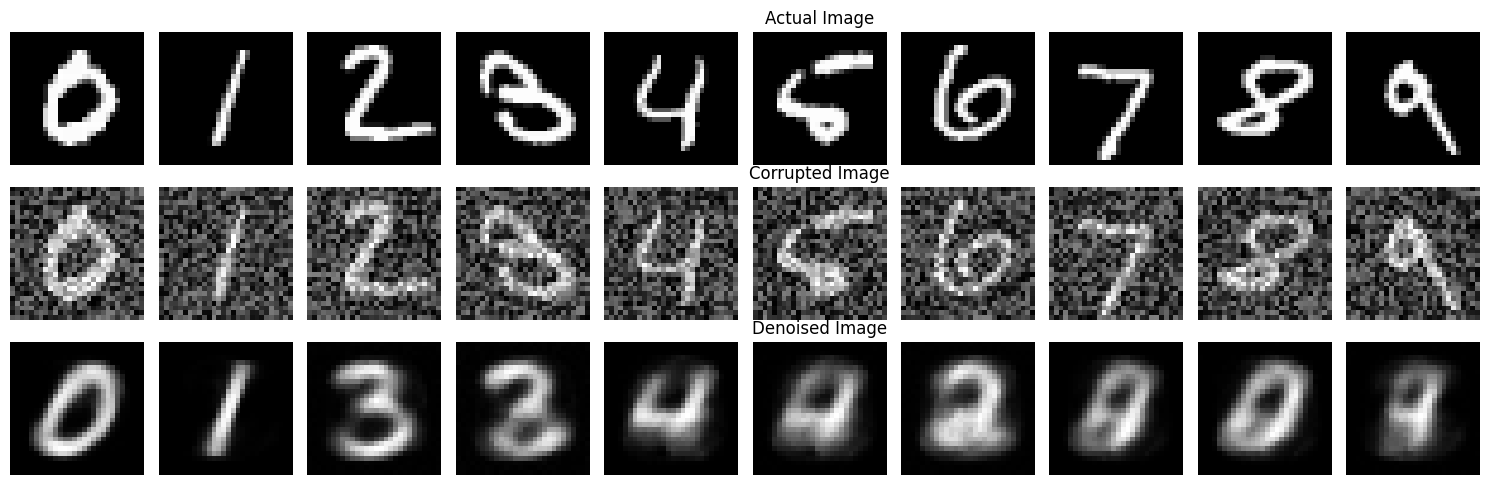

---------------------------------------------Epoch 4/30---------------------------------------------

 	 	 	 train loss 0.040 	 val loss 0.038


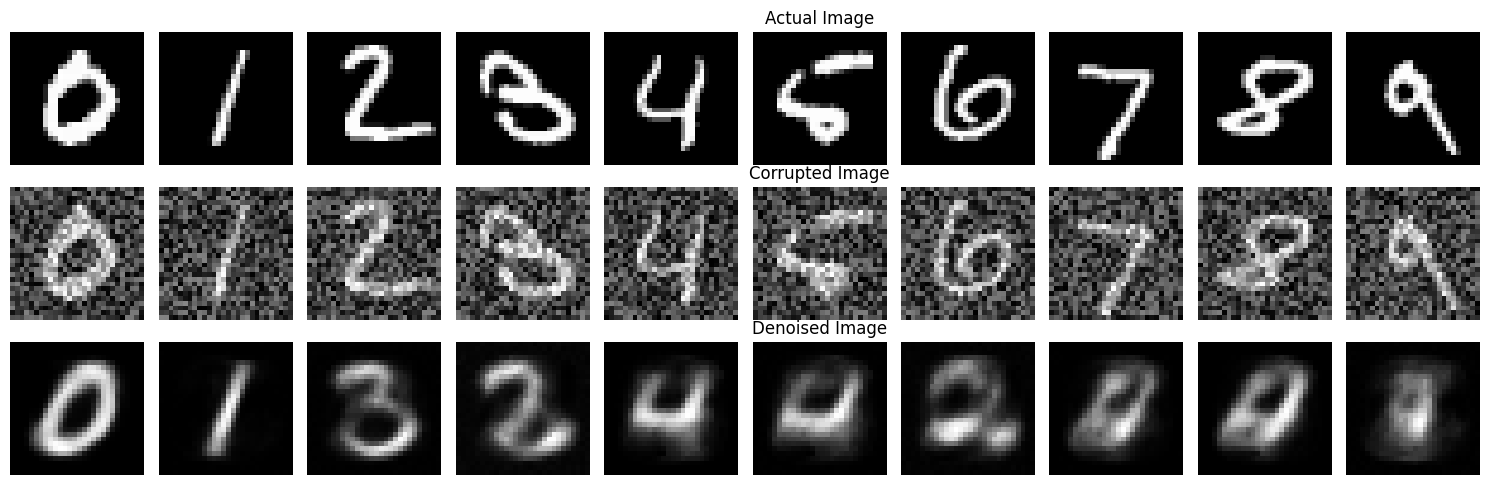

---------------------------------------------Epoch 5/30---------------------------------------------

 	 	 	 train loss 0.037 	 val loss 0.036


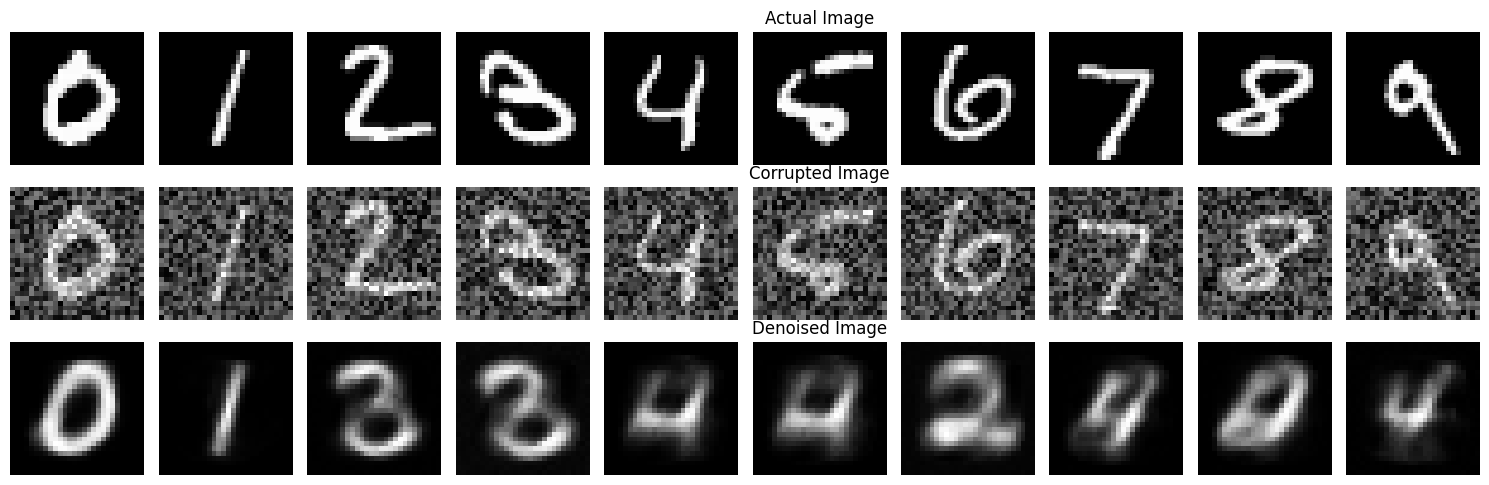

---------------------------------------------Epoch 6/30---------------------------------------------

 	 	 	 train loss 0.035 	 val loss 0.035


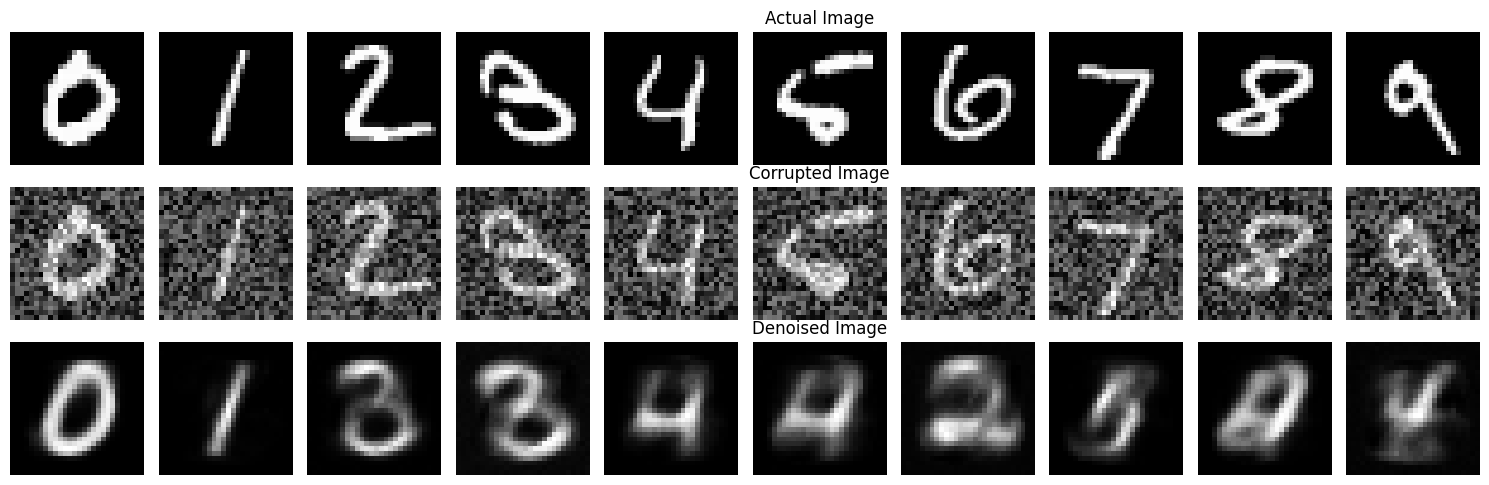

---------------------------------------------Epoch 7/30---------------------------------------------

 	 	 	 train loss 0.033 	 val loss 0.032


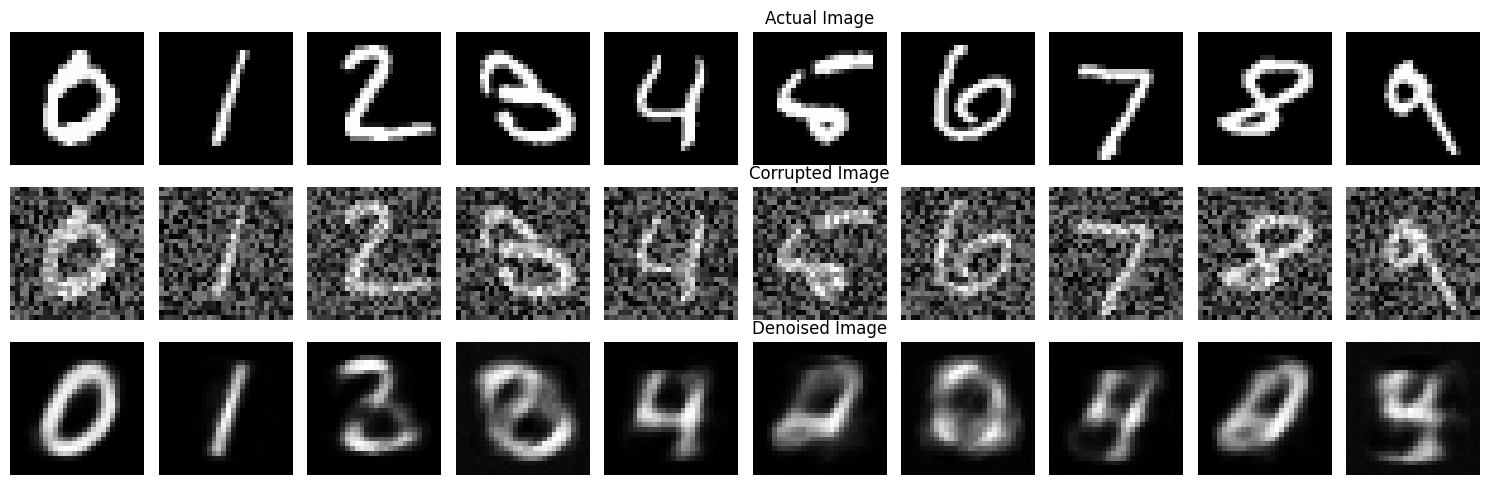

---------------------------------------------Epoch 8/30---------------------------------------------

 	 	 	 train loss 0.031 	 val loss 0.031


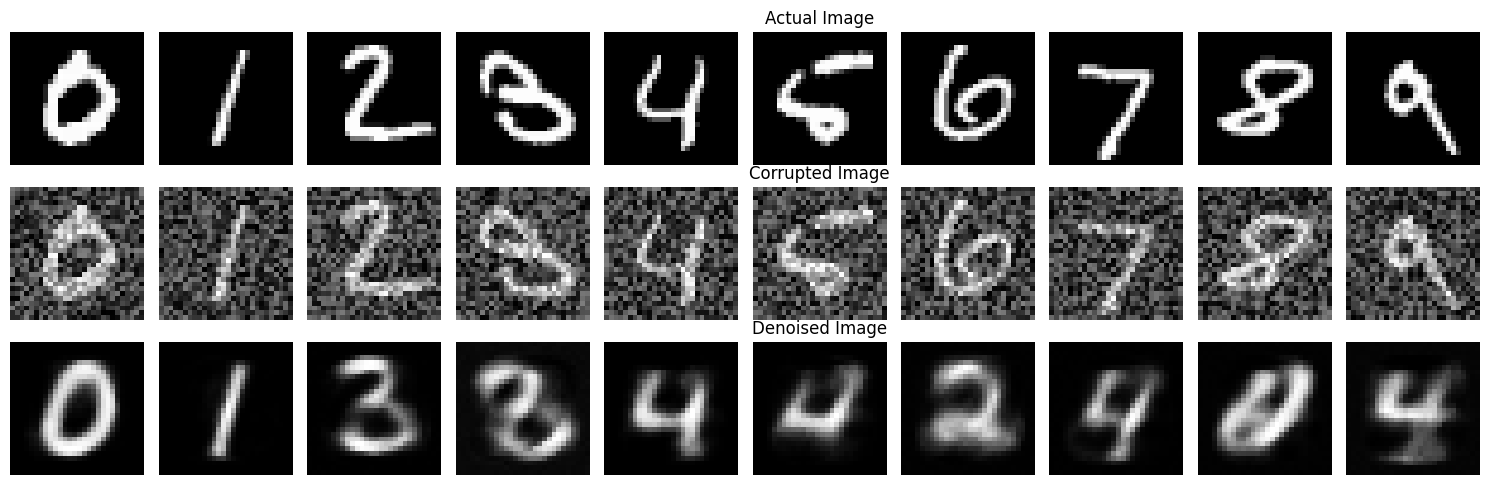

---------------------------------------------Epoch 9/30---------------------------------------------

 	 	 	 train loss 0.030 	 val loss 0.030


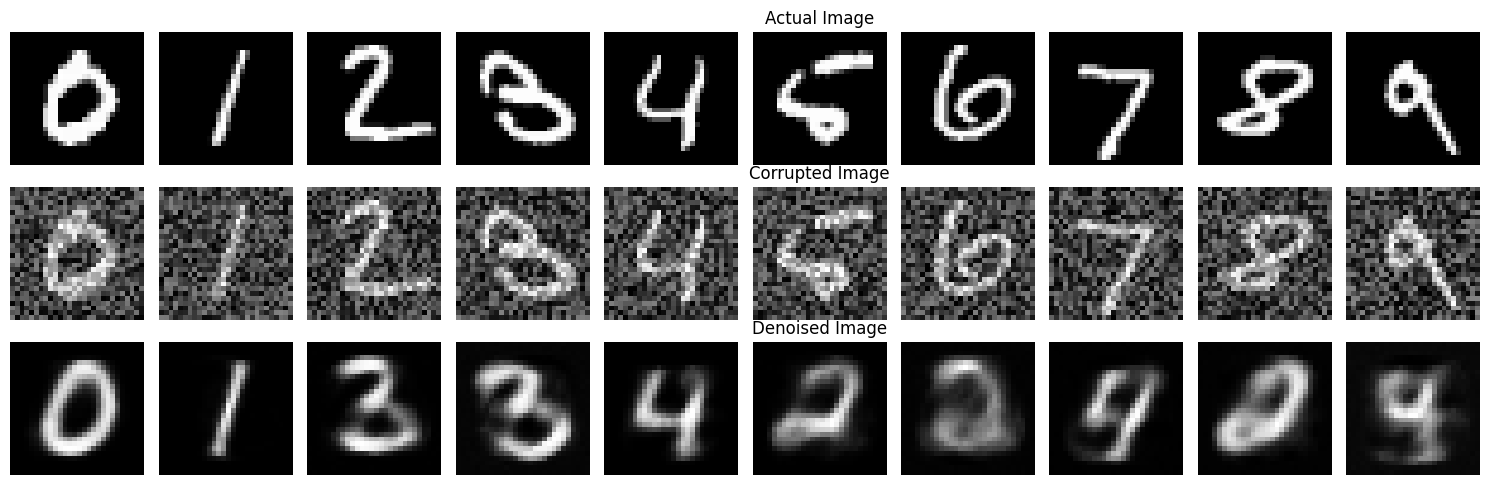

---------------------------------------------Epoch 10/30---------------------------------------------

 	 	 	 train loss 0.030 	 val loss 0.029


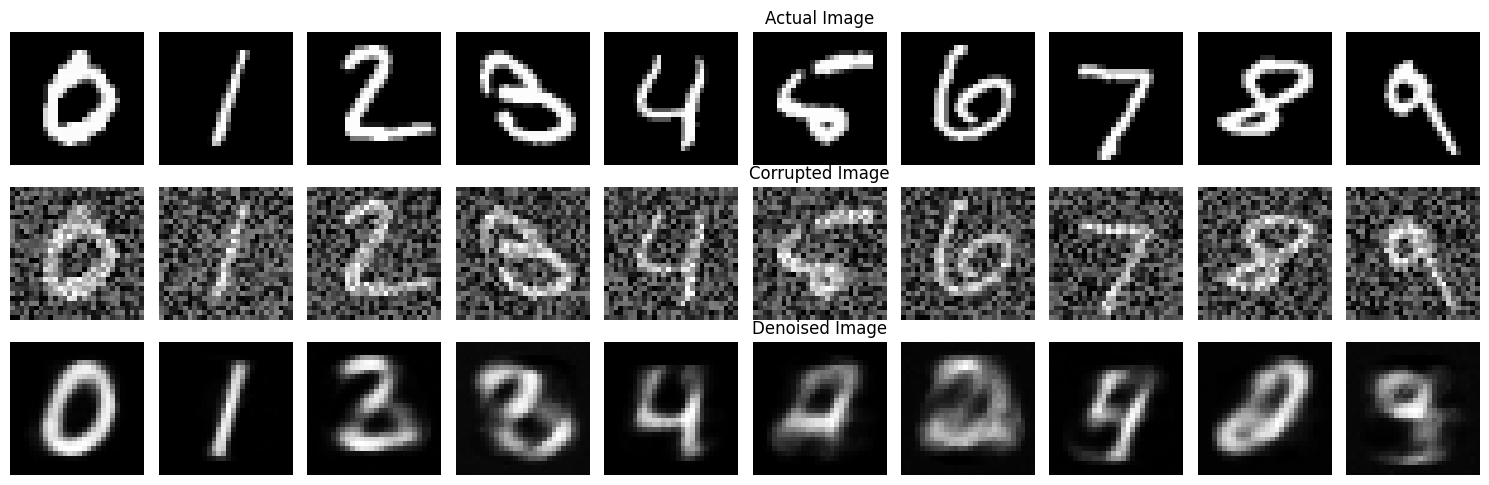

---------------------------------------------Epoch 11/30---------------------------------------------

 	 	 	 train loss 0.029 	 val loss 0.029


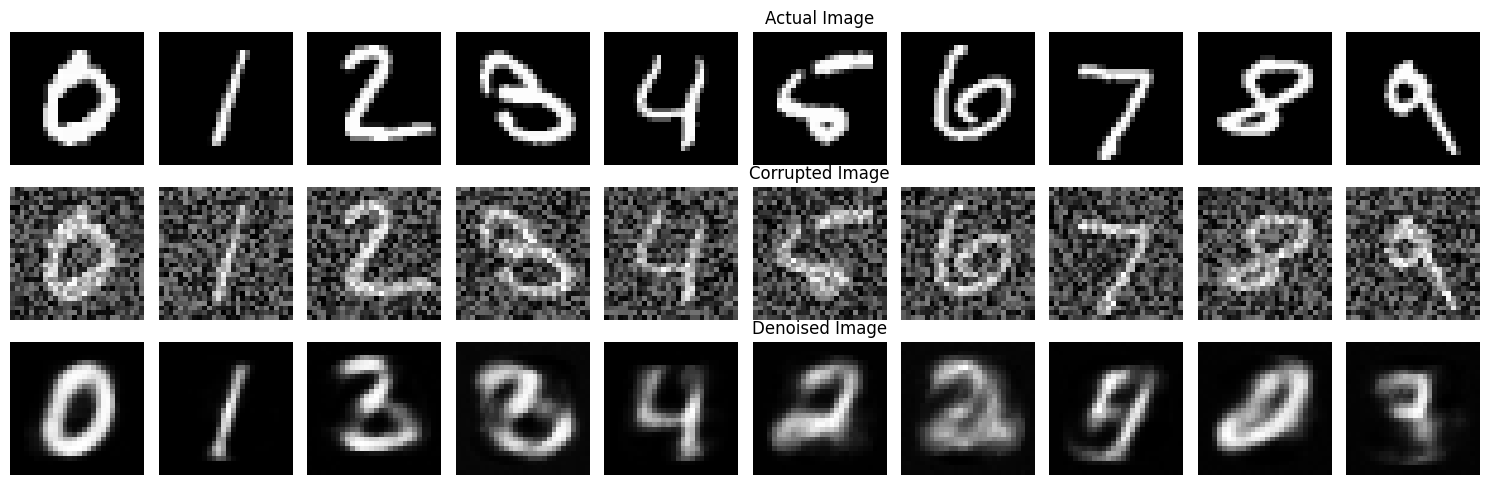

---------------------------------------------Epoch 12/30---------------------------------------------

 	 	 	 train loss 0.028 	 val loss 0.028


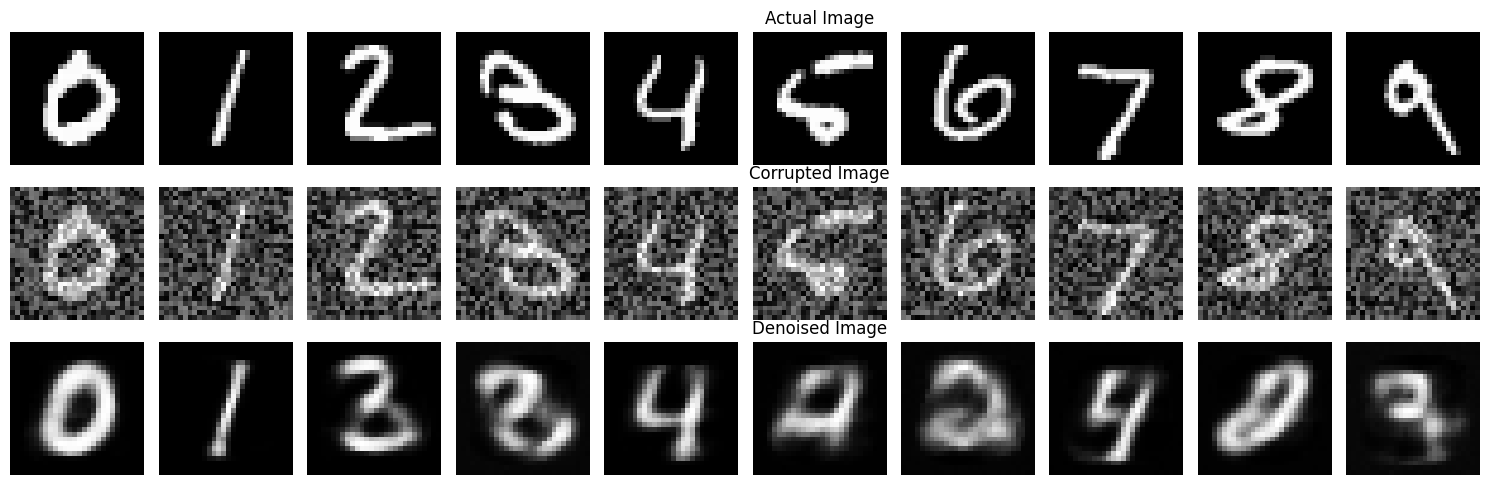

---------------------------------------------Epoch 13/30---------------------------------------------

 	 	 	 train loss 0.028 	 val loss 0.027


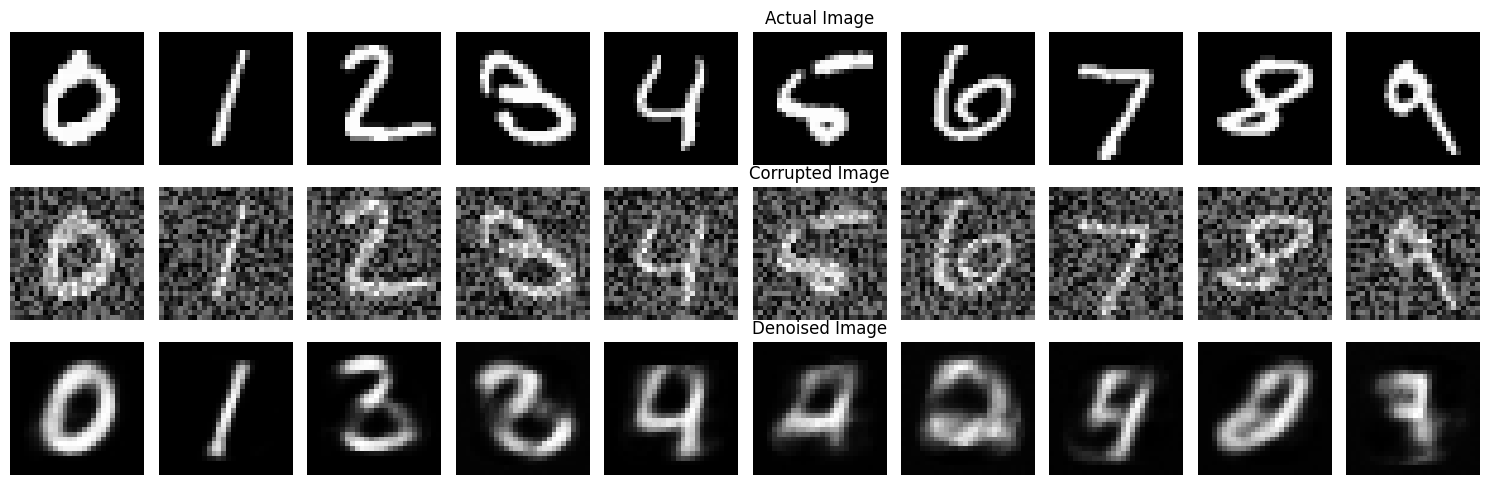

---------------------------------------------Epoch 14/30---------------------------------------------

 	 	 	 train loss 0.027 	 val loss 0.027


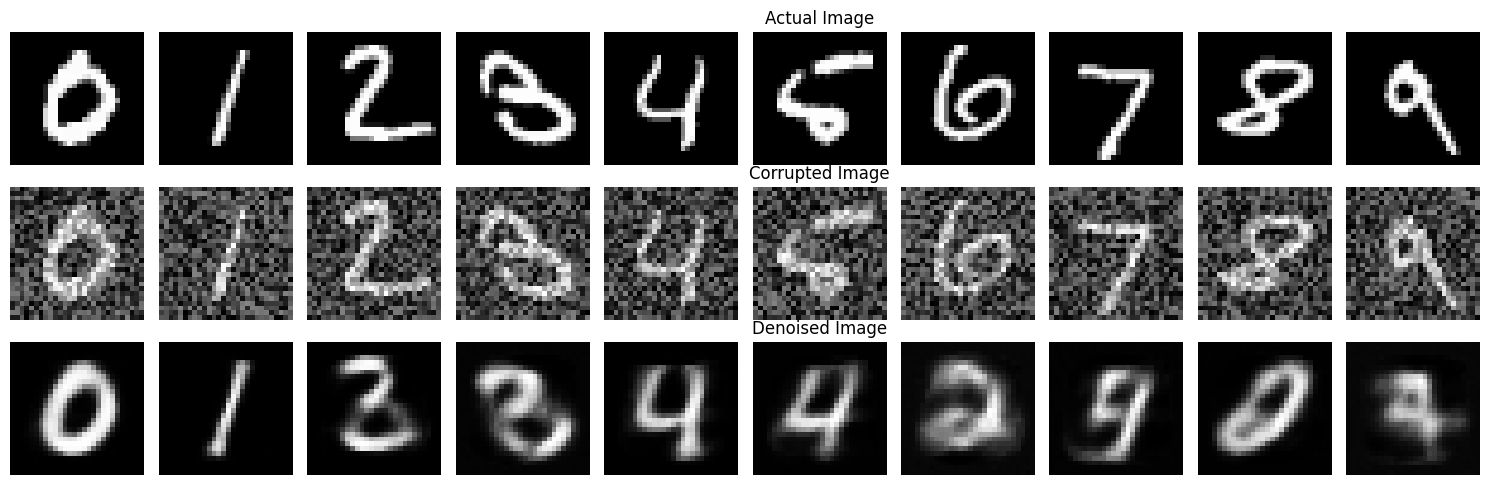

---------------------------------------------Epoch 15/30---------------------------------------------

 	 	 	 train loss 0.026 	 val loss 0.026


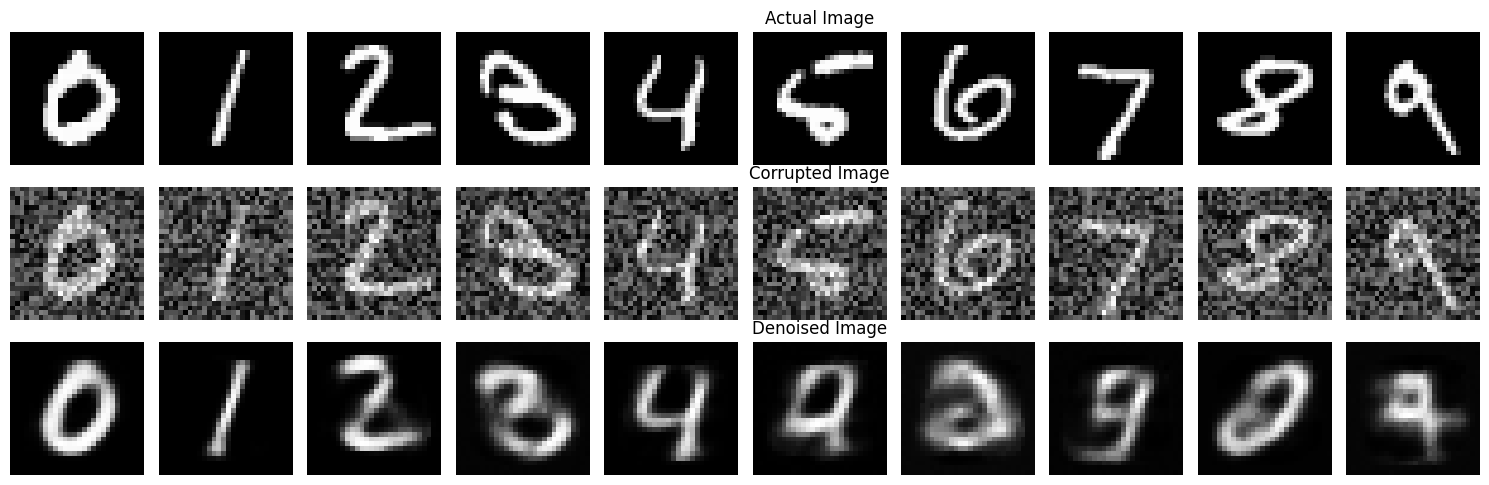

---------------------------------------------Epoch 16/30---------------------------------------------

 	 	 	 train loss 0.025 	 val loss 0.025


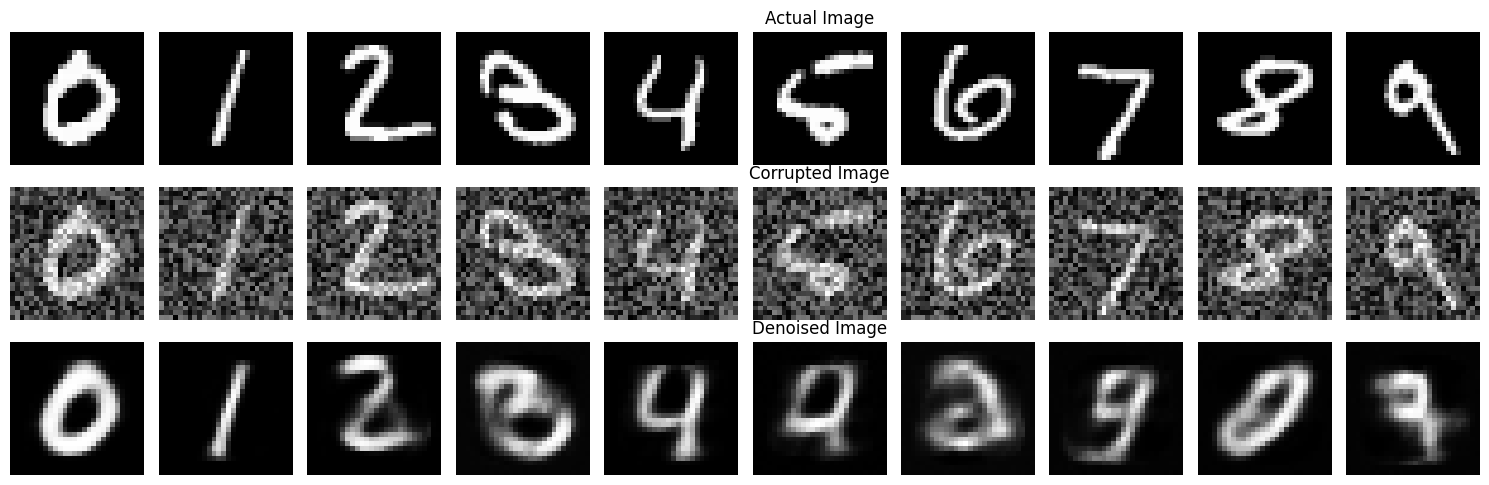

---------------------------------------------Epoch 17/30---------------------------------------------

 	 	 	 train loss 0.025 	 val loss 0.025


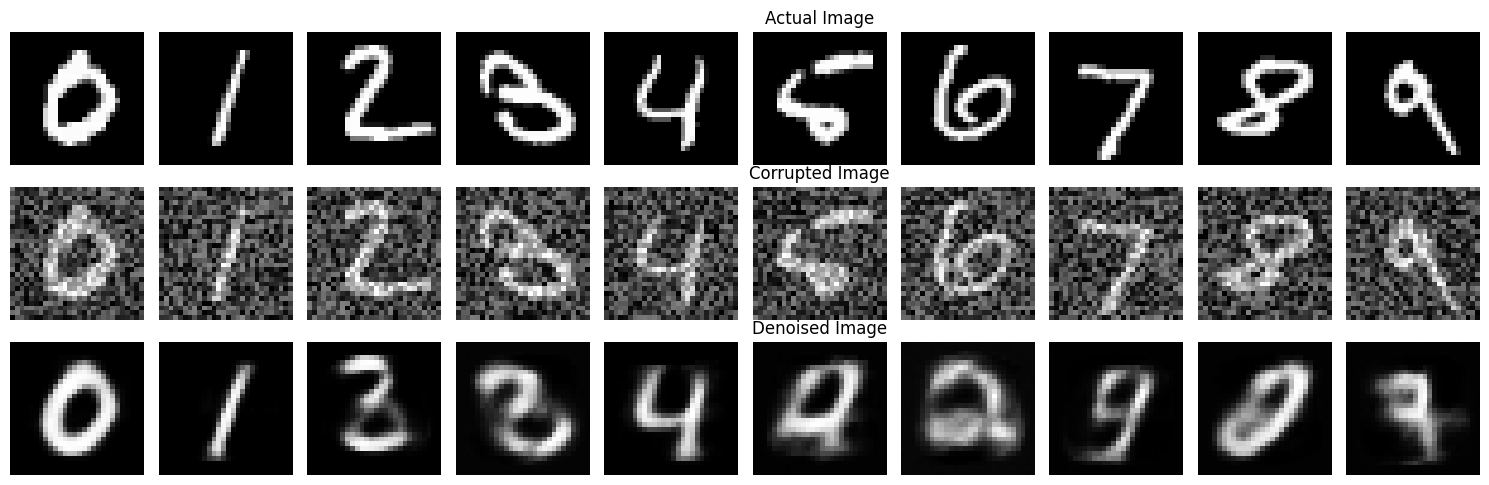

---------------------------------------------Epoch 18/30---------------------------------------------

 	 	 	 train loss 0.024 	 val loss 0.024


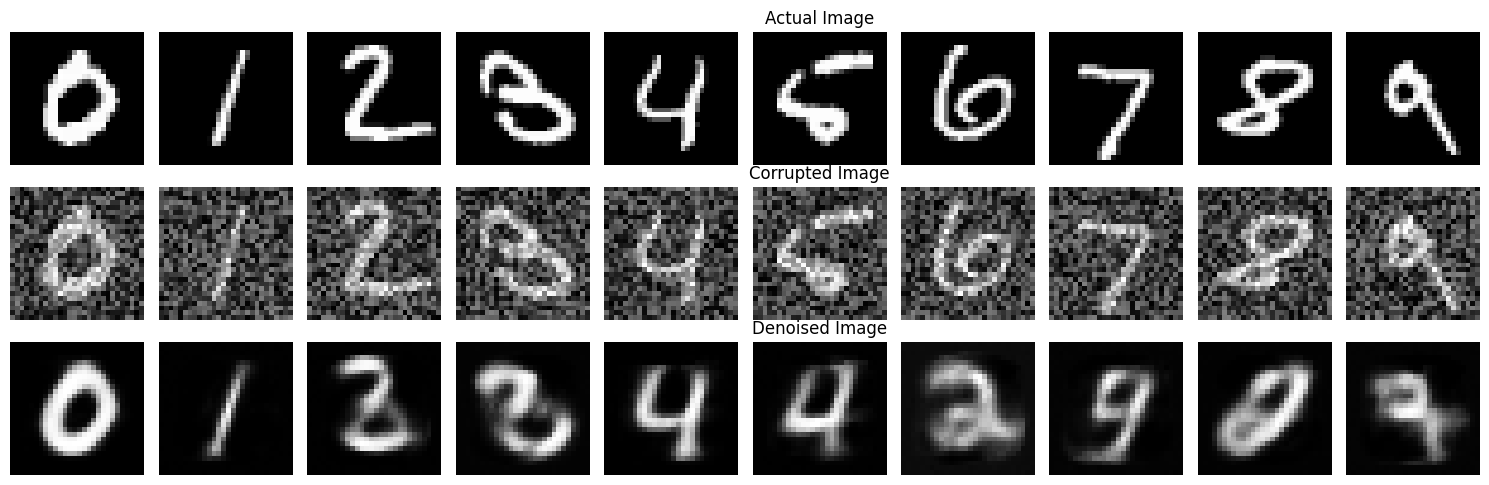

---------------------------------------------Epoch 19/30---------------------------------------------

 	 	 	 train loss 0.024 	 val loss 0.024


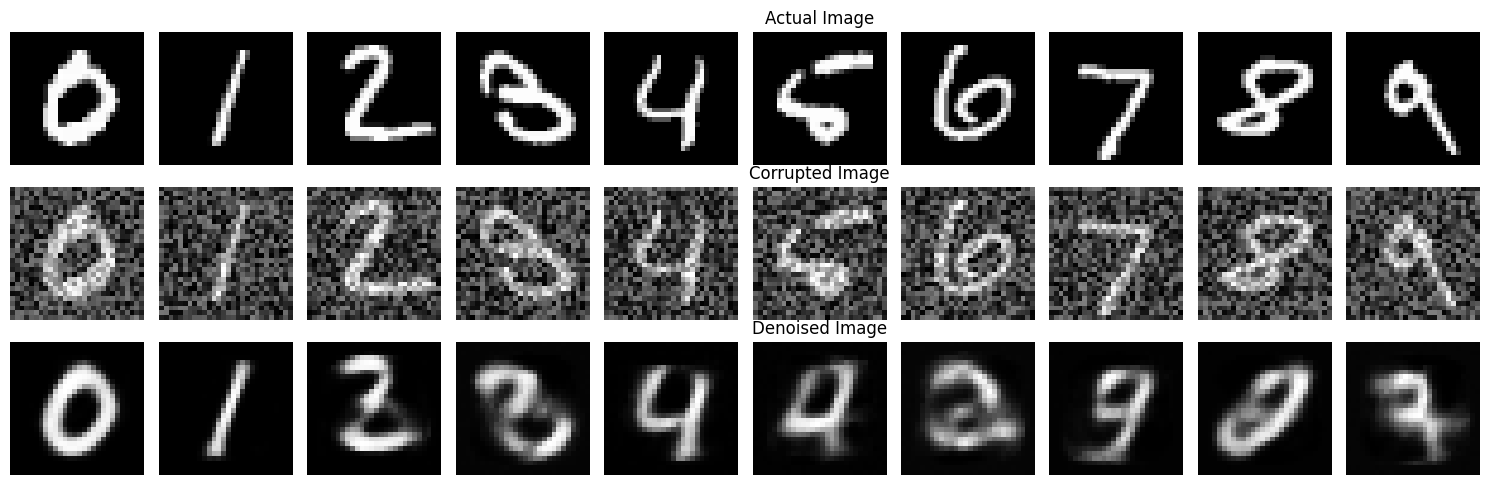

---------------------------------------------Epoch 20/30---------------------------------------------

 	 	 	 train loss 0.023 	 val loss 0.024


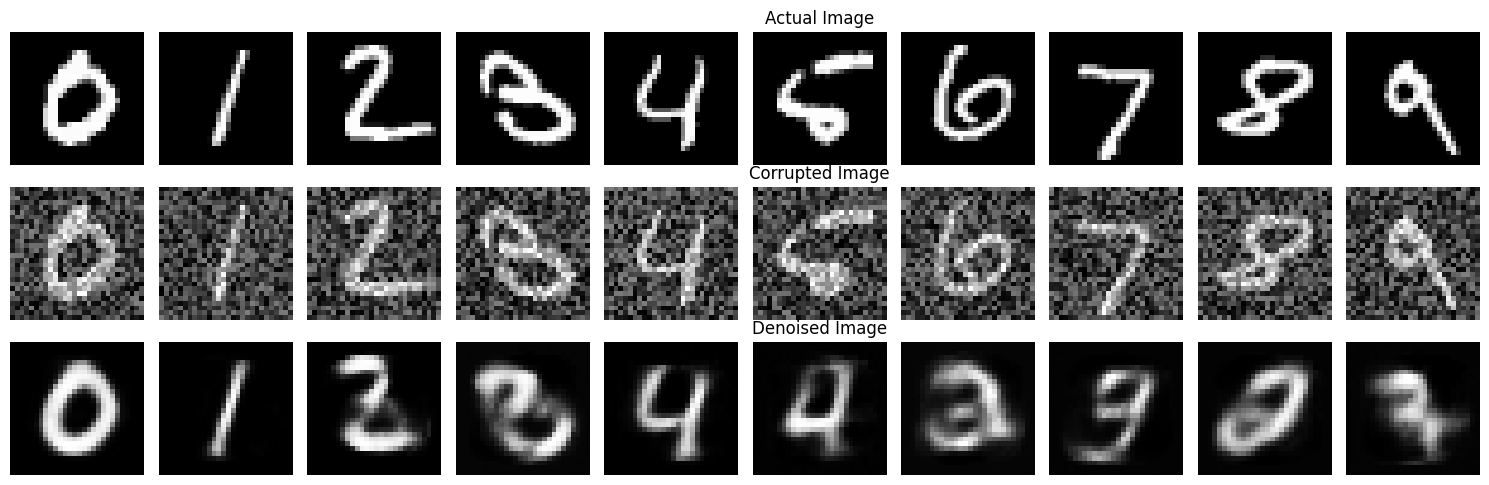

---------------------------------------------Epoch 21/30---------------------------------------------

 	 	 	 train loss 0.023 	 val loss 0.023


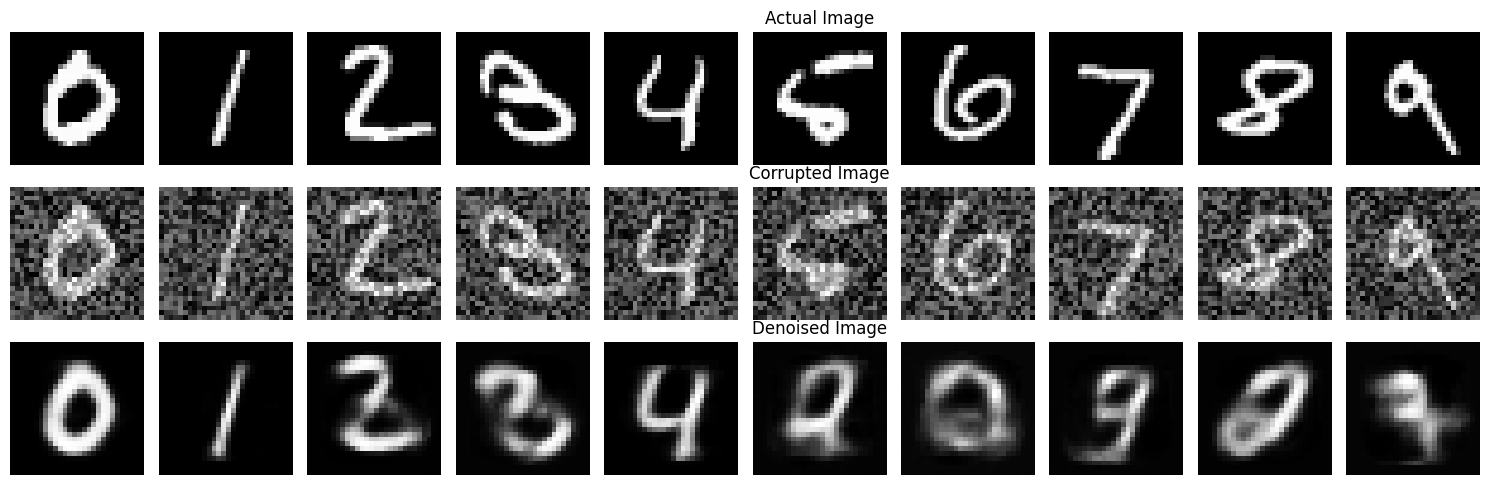

---------------------------------------------Epoch 22/30---------------------------------------------

 	 	 	 train loss 0.023 	 val loss 0.023


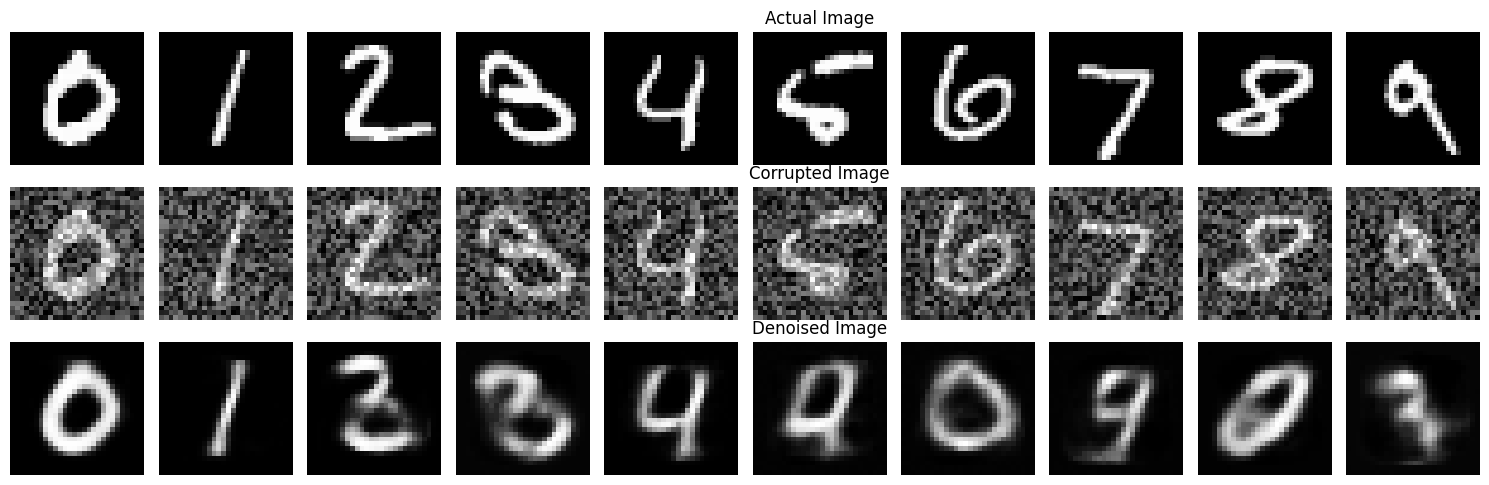

---------------------------------------------Epoch 23/30---------------------------------------------

 	 	 	 train loss 0.023 	 val loss 0.023


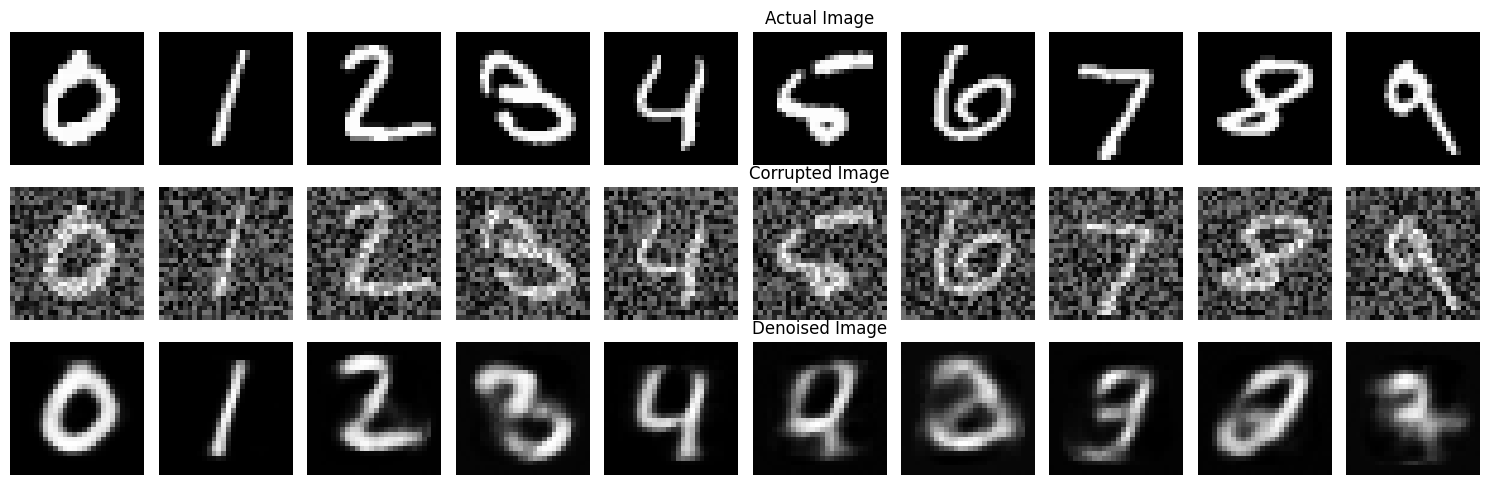

---------------------------------------------Epoch 24/30---------------------------------------------

 	 	 	 train loss 0.023 	 val loss 0.023


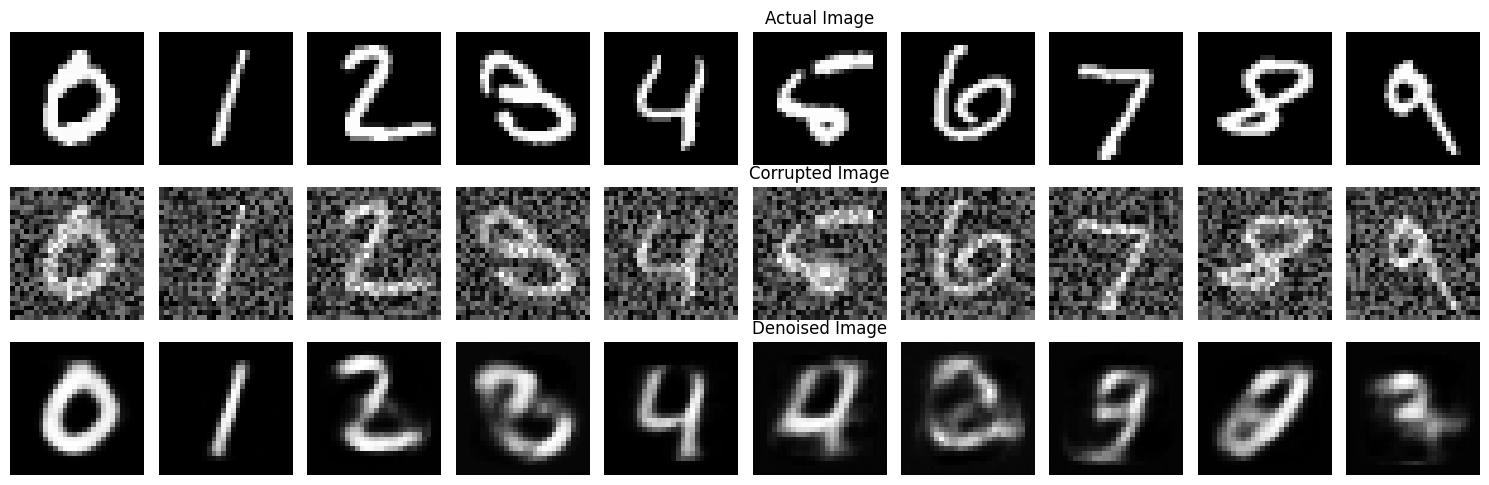

---------------------------------------------Epoch 25/30---------------------------------------------

 	 	 	 train loss 0.022 	 val loss 0.023


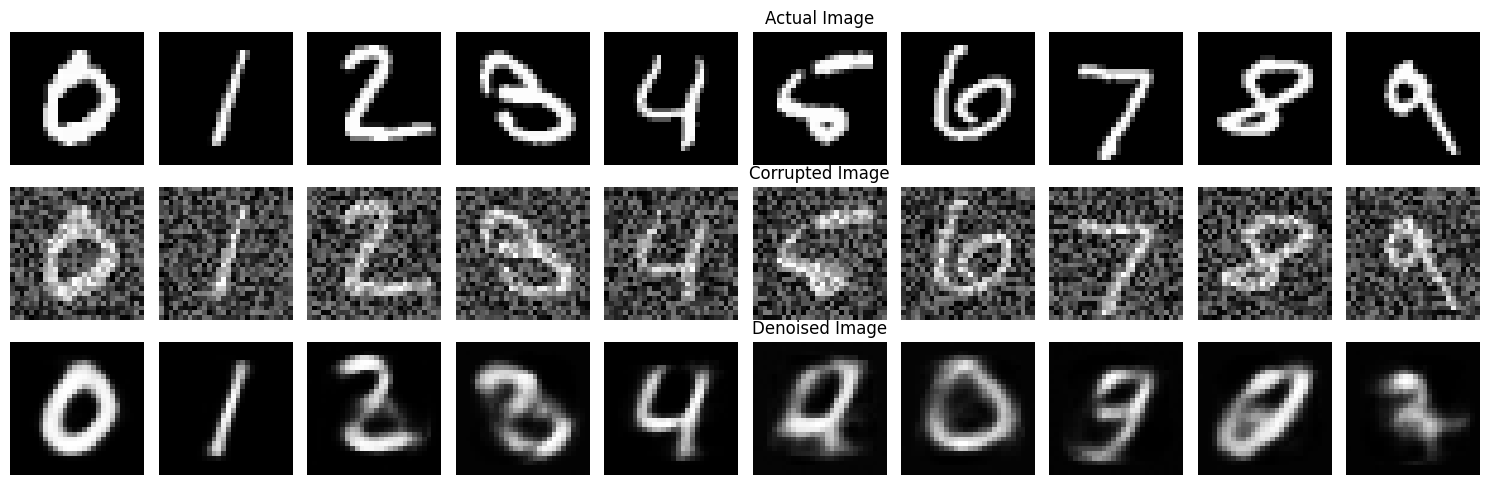

---------------------------------------------Epoch 26/30---------------------------------------------

 	 	 	 train loss 0.022 	 val loss 0.022


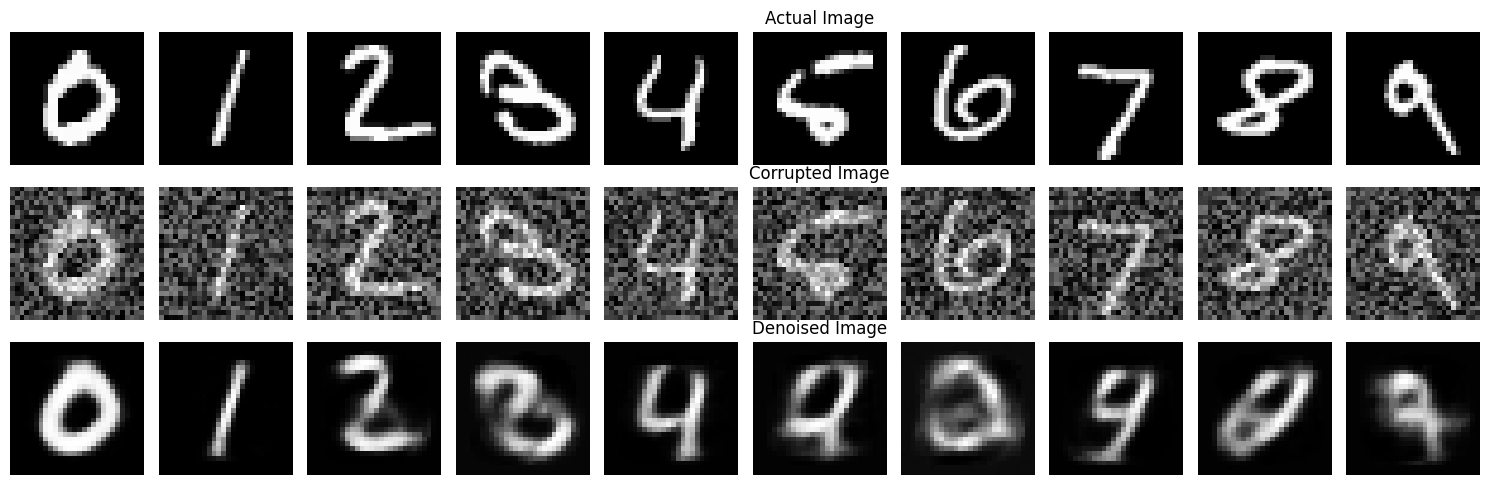

---------------------------------------------Epoch 27/30---------------------------------------------

 	 	 	 train loss 0.022 	 val loss 0.022


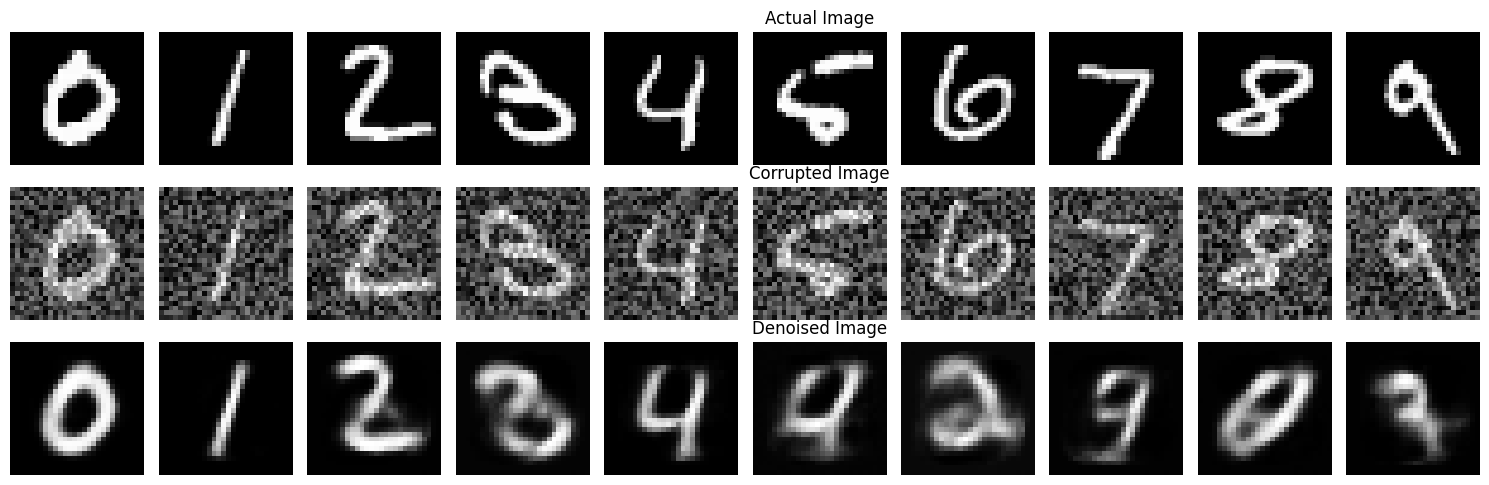

---------------------------------------------Epoch 28/30---------------------------------------------

 	 	 	 train loss 0.022 	 val loss 0.022


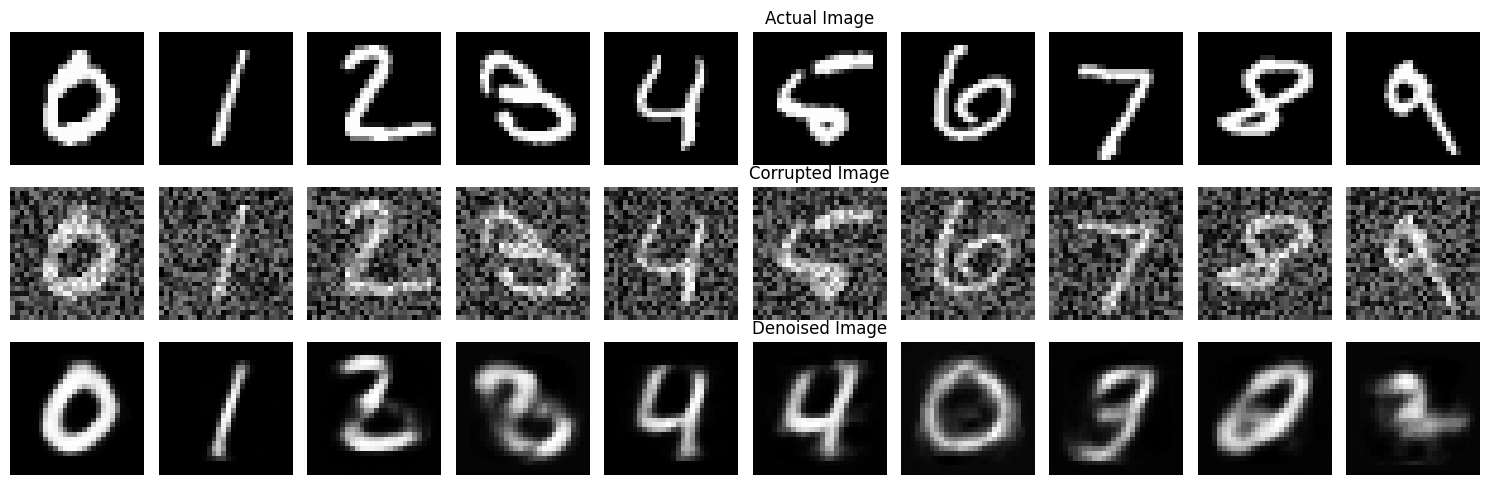

---------------------------------------------Epoch 29/30---------------------------------------------

 	 	 	 train loss 0.022 	 val loss 0.022


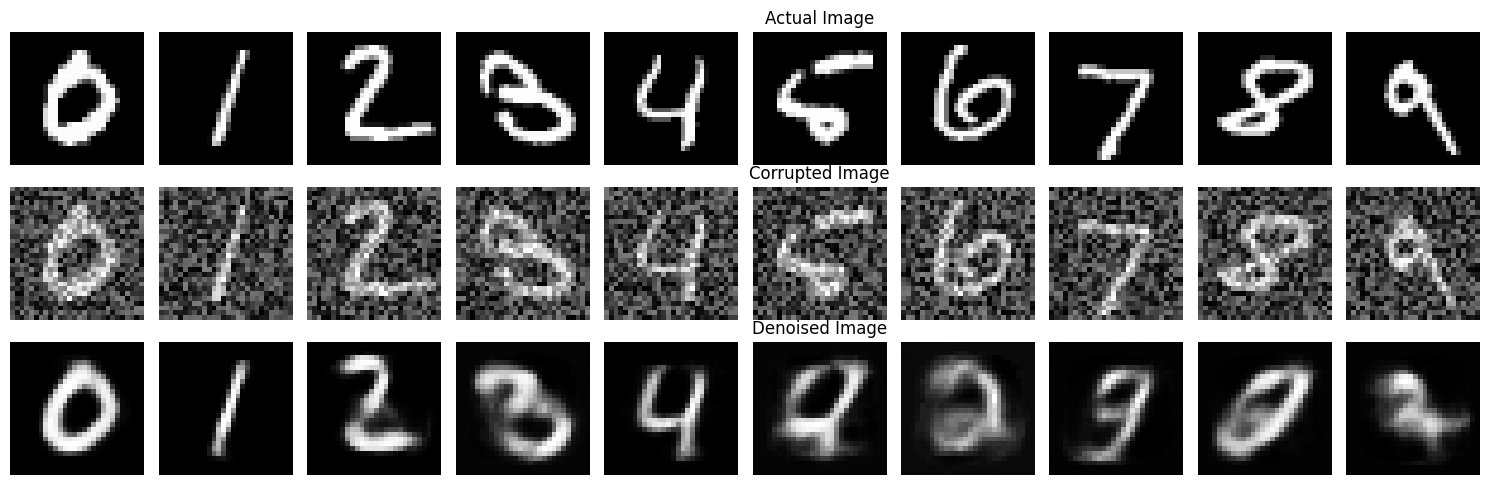

---------------------------------------------Epoch 30/30---------------------------------------------

 	 	 	 train loss 0.022 	 val loss 0.022


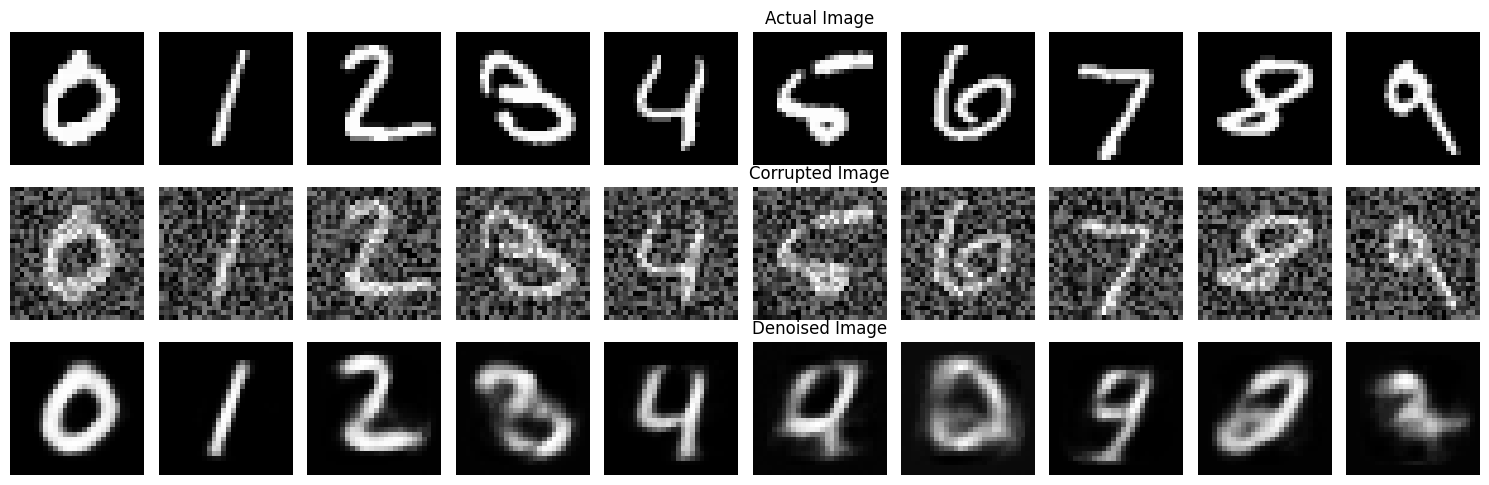

DAE training done!


In [14]:
### Intialize dataloaders
val_split = .2
batch_size=256 

# A trick to include only certain samples in the training. We are showing only samples 0,1,2,3,4 to the DAE while training.
include_samples = [0,1,2,3,4] # to ensure customised training

indices = [idx for idx, target in enumerate(train_data.targets) if target in include_samples]
train_data_new = Subset(train_data, indices) # Only include samples
n_train_samples = len(train_data_new)
train_data_, val_data = random_split(train_data_new, [int(n_train_samples*(1-val_split)), int(n_train_samples*val_split)+1])


train_loader = torch.utils.data.DataLoader(train_data_, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

### Training cycle
noise_factor = 0.3
num_epochs = 30
history={'train_loss':[],'val_loss':[]}

print('DAE training started')
for epoch in range(num_epochs):
    ### Training 
    print(f'---------------------------------------------Epoch {epoch+1}/{num_epochs}---------------------------------------------')
    train_loss=train_dae(
        model=model, 
        input_dim=(-1,28*28),
        device=device, 
        dataloader=train_loader,
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    ### Validation  (use the testing function)
    val_loss = test_dae(
        model=model, 
        input_dim=(-1,28*28),
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validationloss
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    print('\n \t \t \t train loss {:.3f} \t val loss {:.3f}'.format(train_loss,val_loss))
    plot_dae_inference(model,test_dataset=test_data,noise_factor=noise_factor)
print('DAE training done!')

<b>Exercise</b>: How did the DAE denoise the samples from the classes that were excluded from the training? Why do you think that happened?  <br>
<b>Answer</b>: Please type your answer here.....

<b>Exercise</b>: Build a function that draws reconstruction loss for all the labels from the test set. We have already done that with the train data in the code above. Do the same thing on test data, this time instead of bunch of numbers, do it per class and plot the reconstruction error. Simply take MSE between the denoised image and the actual image. Use the `add_noise` function that we provided above. Also check `test_dae` function for more hints on calculating the loss. You can even write your custom MSE!. 
- Use `Subset` on test data for each class
- denoise the images from the class
- Calculate the error for each class
- Plot the values for all 10 classes 

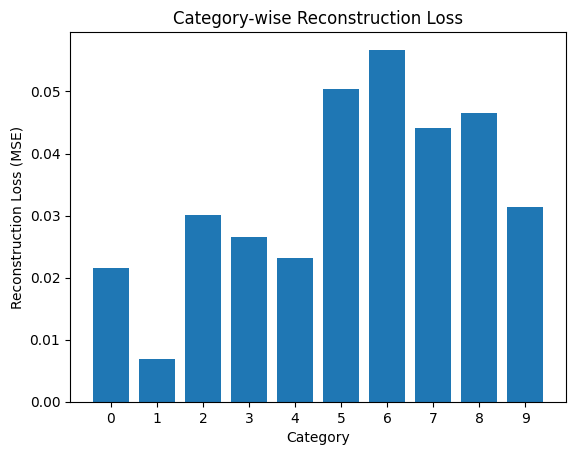

In [17]:
import torch
import matplotlib.pyplot as plt

def cat_recon_loss(model, input_dim, device, dataloader, noise_factor=0.3):
    model.eval()
    with torch.no_grad():
        category_losses = {i: [] for i in range(10)}  # Initialize losses per category

        for images, labels in dataloader:
            noisy_images, _ = add_noise(images, noise_factor)
            images = images.to(device)
            noisy_images = noisy_images.to(device)

            # Reshape images to match input_dim
            noisy_images = torch.reshape(noisy_images,input_dim)
            images = torch.reshape(images,input_dim) 

            # Get denoised images from the model
            denoised_images = model(noisy_images)

            # Calculate loss per category
            for label in labels:
                category = label.item()
                category_losses[category].append(torch.nn.functional.mse_loss(denoised_images[labels == label], images[labels == label], reduction='mean').item())

    return {k: sum(v) / len(v) if v else 0.0 for k, v in category_losses.items()}

# Calculate category-wise reconstruction loss
categorywise_reconstruction_loss = cat_recon_loss(model, input_dim=(-1, 28 * 28), device=device, dataloader=test_loader, noise_factor=0.3)

# Plot the category-wise reconstruction loss
plt.bar(categorywise_reconstruction_loss.keys(), categorywise_reconstruction_loss.values())
plt.xlabel('Category')
plt.ylabel('Reconstruction Loss (MSE)')
plt.xticks(list(categorywise_reconstruction_loss.keys()))
plt.title('Category-wise Reconstruction Loss')
plt.show()